# 

# Step 1 : Introduction on Automated Optical Inspection at Variass
Student: Tobias Schiphorst - S4917340

This notebook is developed to help help Variass in predicting the defect rates of assembled products based on their specifications. Variass is an company specialised in system supply and EMS. Variass industralises and produces hightech electronics in the fields of Defense & Security, Medical and industry. In order to provide and guarantee high quality of its products Variass uses Automated Optical Inspection (AOI) within it's assembly lines. This Automated Optical Inspection is done by an machine that predicts the defects on an product assembly. Each product assembly is registered by an VPL code which indicates the product specifications. When the AOI machine detects an defect it links the VPL code to the defect information. 

The goal of this note book is to create an model that predicts the quality i.e. rate of defects per defect type based on the given VPL codes or a list of vpl codes (bill of materials) of a completely new product. In order to achieve this Variass provided four datasets that will be used to create an master dataset that can be used in an machine learning model. This model is then used to determine the defect rate per defect type based on the product specification. 

This notebook will start with importing the different datasets provided by Variass, then these datasets are merged, aggregated with to create an dataset that can be used for estimating the defect rates overall and per defecttype. Next, the defect rate is predicted using vpl codes and the results are analysed using all inspection data, an data split of 80%-20% and k-fold cross validation. These results will then be summarise in the conclusion & recommendations. 

# Table of Contents

[Step 1 : Introduction](#step-1--introduction-on-automated-optical-inspection-at-variass)

[Step 2 : Data preperation](#step-2--data-preperation)

[Step 3 : Estimation of defect rates](#step-3--defect-rates)

[Step 4 : The model and predictions](#step-4-prediction-tasks-and-performance-reporting)

[Step 5 : Conclusion & Recommendations](#step-5-conclusion--recommendations)

## Importing required modules

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

## Importing the data
Read excel AOI, order list and VPL (taking around 31s) and converting it to csv for better performance

In [136]:
file_path_order = "data/initial/Order picklists.xlsx"
file_path_vpl = "data/initial/VPL list.xlsx"
file_path_alternatives = "data/initial/Alternatives.xlsx"

if not os.path.isfile("data/orders.csv") or not os.path.isfile("data/vpl_codes.csv") or not os.path.isfile("data/alternatives.csv"):
    pd.read_excel(file_path_order).to_csv("data/orders.csv", index=False)
    pd.read_excel(file_path_vpl).to_csv("data/vpl_codes.csv", index=False)
    pd.read_excel(file_path_alternatives).to_csv("data/alternatives.csv", index=False)

Or if the csv files are already there read the new csv files as three new dataframes 

In [137]:
df_aoi_defects = pd.read_csv("data/initial/AOI defects last year.csv")
df_orders = pd.read_csv("data/orders.csv")
df_vpl = pd.read_csv("data/vpl_codes.csv")
df_alternatives = pd.read_csv("data/alternatives.csv")

In [138]:
df_aoi_defects.head()

,overkill,defecttypestring,moduleid,refid,frameid,windowid,isimportantwindow,partnumber,partid,windowtype,...,framerecty4,defectrectx1,defectrectx2,defectrectx3,defectrectx4,defectrecty1,defectrecty2,defectrecty3,defectrecty4,id
0,0,Missing,0,SC68-P,33,2,0,UHW-00003,5532728F-188C-43fc-97D8-C9FBBE46CF3B,1,...,167846.0,499243.0,500321.0,500321.0,499243.0,149534.0,149534.0,150579.0,150579.0,1
1,0,Missing,0,U1-KD,25,0,0,IR9-00013,6DC3F823-57D2-4817-8CC5-53653A2DD0A0,1,...,149048.0,428648.0,436050.0,436050.0,428648.0,114934.0,114934.0,116459.0,116459.0,2
2,0,Missing,0,U1-KD,25,1,0,IR9-00013,6DC3F823-57D2-4817-8CC5-53653A2DD0A0,5,...,149048.0,436675.0,448295.0,448295.0,436675.0,117988.0,117988.0,119084.0,119084.0,3
3,0,Missing,0,U1-KD,25,2,0,IR9-00013,6DC3F823-57D2-4817-8CC5-53653A2DD0A0,5,...,149048.0,424899.0,436519.0,436519.0,424899.0,117991.0,117991.0,119087.0,119087.0,4
4,0,Missing,0,U1-KD,25,3,0,IR9-00013,6DC3F823-57D2-4817-8CC5-53653A2DD0A0,1,...,149048.0,437847.0,440247.0,440247.0,437847.0,120726.0,120726.0,123247.0,123247.0,5


In [139]:
df_orders.head()

,Order,part number,total amount
0,1036933,CAP-00693,504.0
1,1036933,CMO-00180,252.0
2,1036933,CZZ-00214,252.0
3,1036933,CZZ-00215,252.0
4,1036933,CZZ-00216,252.0


In [140]:
df_vpl.head()

,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead type,Pitch,Subtype
0,VVH-00021,TSM4ZJ202KR10,PDSO-J3/XX-L48W46T37,P,D,SO,J3,X,X
1,INS-00410,LF353M/NOPB,PDSO-G8/FX-L49W39T18,P,D,SO,G8,F,X
2,VWO-00003,82541300,XDXD-R2/XR-L32W16T15,X,D,XD,R2,X,R
3,FMU-00181,NFM3DCC102R1H3L,XXXD-R3/XL-L32W13T7,X,X,XD,R3,X,L
4,KKT-00218,T495X337K010ATE100,PDSO-C2/XX-L73W43T40,P,D,SO,C2,X,X


In [141]:
df_alternatives.head()

,Original Part,description,Alternative Part,description.1
0,KS55-00005,SMD 330nF 10% 100V X7R 2220 SYF,KKT-00219,SMD 330nF 5% 100V X7R 2220 KEM
1,WBO-00013,SMD 240R 1% 0.25W 1206 100ppm BOU,WVH-00813,SMD 240R 1% 0.25W 1206 100ppm VIS
2,KSI-00076,#SMD 22pF 5% 50V C0G 0603 EPC,KYA-00007,SMD 22pF 5% 50V C0G 0603 YAG
3,KSI-00076,#SMD 22pF 5% 50V C0G 0603 EPC,KYA-00007,SMD 22pF 5% 50V C0G 0603 YAG
4,KSI-00076,#SMD 22pF 5% 50V C0G 0603 EPC,KYA-00007,SMD 22pF 5% 50V C0G 0603 YAG


## First look at the four created dataframes
After creating four different dataframes and looking at the information from the assignment case and lecture slides we can observe an describe the following: 

### df_aoi_defects
- *defecttypestring* = Defecttypestring: type of defect
- *reviewd* = 2 after manual inspection the 3D defect is approved, 1 after manual inspection the 3D defect is disapproved (false call)
- *refid* = reference identification with is the position at the PCBA
- *Partnumber* = link to the orderpick list and VPL list

### df_orders
- *Order* = each order corresponds to an part needed for that order and its total amount
- *part number* = each part number corresponds an specific part needed for that specific assembly order
- *total amount* = total amount of parts needed to fulfil the order 

### df_vpl
- *partnumber* = each partnumber within this dataframe has an corresponding VPL code
- *VPL package* = unique code that describes the assembly used by Variass 

![VPL code meaning](./context/VPL.png)

### df_alternatives
Variass sources parts from different suppliers. The effect of this is that there are sometimes different partnumber names for the same part.
- *Orginal part* = the orginal part used in the assembly process
- *Alternative part* = provided by the supplier to replace the orginal part in which an orginal part can have multiple alternative parts.

With the dataframes ready and the data imported we can go to the next step of data preperation for analysis.

# Step 2 : Data preperation 
**Assignment:** The first step of the analysis is to collect the relevant data from different files and bring the
information together in some form that facilitates your analysis. For instance, it should be
clear that you need to match partnumber’s with VPL codes to aggregate order- and defectrelated data. In preparing your data, consider creating quantitative or numerical attributes
out of ‘coded’ attributes.

Let's first look if that four different dataframes have any missing values. Based on the information of the case and slides we can take a look at specific columns per dataframe

In [142]:
print("df_aoi_defects")
print(df_aoi_defects[["reviewed", "defecttypestring", "refid", "partnumber"]].isnull().sum())
print("\ndf_orders")
print(df_orders[["Order", "part number", "total amount"]].isnull().sum())
print("\ndf_vpl")
print(df_vpl[["partnumber", "VPLpackage"]].isnull().sum())
print("\ndf_alternative")
print(df_alternatives[["Original Part", "Alternative Part"]].isnull().sum())

df_aoi_defects
reviewed               0
defecttypestring    5655
refid                  0
partnumber          4305
dtype: int64

df_orders
Order           0
part number     0
total amount    0
dtype: int64

df_vpl
partnumber    0
VPLpackage    0
dtype: int64

df_alternative
Original Part       0
Alternative Part    0
dtype: int64


We observe that df_aoi_defects has nan values in columns defecttypestring and partnumber, the other dfs don't have nan values. Focussing at the df_aoi_defects specifically starting with the partnumber column the nan values in this column pose an problem, because without an partnumber no link can be made between the other dfs. The missing values on the defecttypestring column are also problematic I assume that in this case an defect has be registered by the AOI machine but no defect type could be linked to it. Lets analyse this further by using the value_counts function.        

In [143]:
df_aoi_defects[df_aoi_defects["defecttypestring"].isnull()][["reviewed", "defecttypestring", "refid", "partnumber"]].head()

,reviewed,defecttypestring,refid,partnumber
655,1,NaN,R106,WVH-00458
684,1,NaN,C452,KAX-00382
808,2,NaN,R406,WYA-00247
927,2,NaN,R410,WYA-00247
951,2,NaN,R430,WYA-00247


As we observe the first 5 rows having an defectypestring of we see true-positives and false positives. This means that the machine defected an defect and this was in some cases accepted by the manual inspection, but propably the type of defect is not registered in the vpl code at Variass. Lets look even further into this. 

In [144]:
df_aoi_defects[df_aoi_defects["defecttypestring"].isnull()].value_counts("reviewed")


reviewed
2    5409
1     246
dtype: int64

As we can see the alot of the rows that cannot be linked to an defecttypestring are reviewed as an true defect (5409). I think that this has to do with that the machine found an new type of defect that isn't yet in registered in the VPL codes, But an defect it is non the less.  

**To conclude**

Having nan values in the partnumber columns in the df_aoi_defects is an problem because we cannot match this with the other dataframes. Therefore, these rows should be excluded from the analysis. For the defecttypestring however its difficult on the one hand you the AOI machine detected I assume these new defects and this should be taken into account in calculating the total defect rate, but on the other hand these rows cannot be used for specific analysis on defect types. For now we will remove the partnumber having nan values and leave the nan valued defecttypestrings in the dataframe.

Next, we will look at the VPL codes in df_vpl.

In [145]:
df_vpl.head()

,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead type,Pitch,Subtype
0,VVH-00021,TSM4ZJ202KR10,PDSO-J3/XX-L48W46T37,P,D,SO,J3,X,X
1,INS-00410,LF353M/NOPB,PDSO-G8/FX-L49W39T18,P,D,SO,G8,F,X
2,VWO-00003,82541300,XDXD-R2/XR-L32W16T15,X,D,XD,R2,X,R
3,FMU-00181,NFM3DCC102R1H3L,XXXD-R3/XL-L32W13T7,X,X,XD,R3,X,L
4,KKT-00218,T495X337K010ATE100,PDSO-C2/XX-L73W43T40,P,D,SO,C2,X,X


The df_vpl consists of partnumber, mpn, vpl code, followed by 6 columns containing substrings of the vpl code with all include some information. Let's take the vpl code from the first row and explain last 6 columns.

![VPL code meaning](./context/VPL.png)

VPLpackage of the first row is PDSO-J3/XX-L48W46T37:
- Material type is the P in **P**DSO-J3/XX-L48W46T37 which equals plastic
- Position type is the D in P**D**SO-J3/XX-L48W46T37
- Package type is the SO in PD**SO**-J3/XX-L48W46T37
- Leadtype is the J3 in PDSO-**J3**/XX-L48W46T37 
- Pitch is the X in PDSO-J3/**X**X-L48W46T37
- Subtype is the X in PDSO-J3/X**X**-L48W46T37 
- Length is the L48 in PDSO-J3/XX-**L48**W46T37
- Width is the W46 in PDSO-J3/XX-L48**W46**T37
- Height is the T37 in PDSO-J3/XX-L48W46**T37**

Note that Lead form and lead count in the image are combined in df_vpl and that the Length, Width and Height should ideally have there own columns like Material type, Position type, Package type, Lead type, Pitch and Subtype and the Lead type column should be split into two different columns for lead form and lead count. Let's start with the implementation of these suggestions. 

Starting with the lead type let's look first what type of values the lead type column consists of by using str function to extract the lead form and lead count.  

In [146]:
df_vpl["Lead type"].str[0].value_counts()

R    5921
G    4890
N    1797
C    1092
W     866
F     689
P     662
T     549
L     497
B     277
J      96
X      88
Y       1
Name: Lead type, dtype: int64

The first part of the lead type is an letter depicting the form type of the assembly. Now lets check the let counts (number of lead forms on the assembly).

In [147]:
df_vpl["Lead type"].str[1:].value_counts()

2         8658
8         1550
3         1156
4          951
6          624
          ... 
16(28)       1
5(12)        1
357          1
684          1
94           1
Name: Lead type, Length: 178, dtype: int64

As the first element of the lead type is the form type of the assembly the rest are number or count of these types of lets. Running an value counts function on this subset results in numbers, but also numbers with parentheses around them which is strange. Lets look deeper in these numbers with parentheses 

In [148]:
# source: https://stackoverflow.com/questions/58478230/how-to-return-match-with-a-string-that-contains-parentheses-in-pandas
print("Number of rows in lead type with parentheses in them are", df_vpl["Lead type"].str[1:].str.contains("\)|\(").sum())
df_vpl[df_vpl["Lead type"].str[1:].str.contains("\)|\(")].head()

Number of rows in lead type with parentheses in them are 50


,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead type,Pitch,Subtype
385,000000000000421299,09 03 164 6921,PDXC-T66(98)/HH-L940W130T110,P,D,XC,T66(98),H,H
1555,CHX-00024,09 03 164 6921,PDXC-T66(98)/HH-L940W130T110,P,D,XC,T66(98),H,H
1557,CHX-00033,09 03 164 6921,PDXC-T66(98)/HH-L940W130T110,P,D,XC,T66(98),H,H
3368,ILT-00100,LTC1535CSW#PBF,PDSO-G16(28)/FX-L179W75T25,P,D,SO,G16(28),F,X
3727,IHU-00009,HY534256ALJ-60,PDSO-J20(26)/FG-L171W76T36,P,D,SO,J20(26),F,G


As we don't really know why there are 50 vplpackages that have parentheses in them. The first row also has an weird partnumber and mpn of only integers. As this these VPLpackage codes are not valid VPL codes we will remove them from the dataset. 

In [149]:
df_vpl = df_vpl[~df_vpl["Lead type"].str[1:].str.contains("\)|\(")]
print("Number of rows in lead type with parentheses in them are", df_vpl["Lead type"].str[1:].str.contains("\)|\(").sum())

Number of rows in lead type with parentheses in them are 0


Now we can focus on the splitting of the lead type into lead form and lead count. 

In [150]:
df_vpl["Lead form"] = df_vpl["Lead type"].str[0]
df_vpl["Lead count"] = df_vpl["Lead type"].str[1:].astype(int)
df_vpl.drop(columns=["Lead type"])
df_vpl = df_vpl[["partnumber", "mpn", "VPLpackage", "Material type", "Position type", "Package type", "Lead form", "Lead count", "Pitch", "Subtype"]]
df_vpl.head()

,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype
0,VVH-00021,TSM4ZJ202KR10,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X
1,INS-00410,LF353M/NOPB,PDSO-G8/FX-L49W39T18,P,D,SO,G,8,F,X
2,VWO-00003,82541300,XDXD-R2/XR-L32W16T15,X,D,XD,R,2,X,R
3,FMU-00181,NFM3DCC102R1H3L,XXXD-R3/XL-L32W13T7,X,X,XD,R,3,X,L
4,KKT-00218,T495X337K010ATE100,PDSO-C2/XX-L73W43T40,P,D,SO,C,2,X,X


The Leadtype is split between Lead form and Lead count (like in the image), now let's extract the Length, Width and Height out of the VPLpackage columns and assign these values to three columns as well. 

In [151]:
df_vpl.head()

,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype
0,VVH-00021,TSM4ZJ202KR10,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X
1,INS-00410,LF353M/NOPB,PDSO-G8/FX-L49W39T18,P,D,SO,G,8,F,X
2,VWO-00003,82541300,XDXD-R2/XR-L32W16T15,X,D,XD,R,2,X,R
3,FMU-00181,NFM3DCC102R1H3L,XXXD-R3/XL-L32W13T7,X,X,XD,R,3,X,L
4,KKT-00218,T495X337K010ATE100,PDSO-C2/XX-L73W43T40,P,D,SO,C,2,X,X


In [152]:
df_l_w_t = df_vpl["VPLpackage"].str.split("-").str[-1].str.split("L|W|T", n=3, expand=True) 
df_l_w_t.columns = [0, "L", "W", "T"]
df_vpl["L"], df_vpl["W"], df_vpl["T"] = df_l_w_t["L"].astype(int), df_l_w_t["W"].astype(int), df_l_w_t["T"].astype(int)
df_vpl.head()

,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T
0,VVH-00021,TSM4ZJ202KR10,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37
1,INS-00410,LF353M/NOPB,PDSO-G8/FX-L49W39T18,P,D,SO,G,8,F,X,49,39,18
2,VWO-00003,82541300,XDXD-R2/XR-L32W16T15,X,D,XD,R,2,X,R,32,16,15
3,FMU-00181,NFM3DCC102R1H3L,XXXD-R3/XL-L32W13T7,X,X,XD,R,3,X,L,32,13,7
4,KKT-00218,T495X337K010ATE100,PDSO-C2/XX-L73W43T40,P,D,SO,C,2,X,X,73,43,40


The VPLpackage column in df_vpl was splitted based on the dash (-) at first, making the last element the LxxWxxTxx of the VPL code which we need. Next, an second split on this last element based on the characters L or W or T with an max split of 3 times and expanded to an new dataframe called df_l_w_t. These columns are then allocated to the df_vpl as columns L, W and T converted as integers. Now the Length, width and height are extracted from the VPLpackage column we can go further an merge the dataframes.    

## Alternatives
As Variass sources parts from different suppliers, it can occure that different partnumbers are equally the same part. Therefore, we have to check and if needed combine the alternative dataset with the different datasets. 

In [153]:
df_alternatives = df_alternatives.drop(labels=["description", "description.1"], axis=1)
df_alternatives = df_alternatives.rename(columns={"Original Part":"partnumber"})
df_alternatives.head()

,partnumber,Alternative Part
0,KS55-00005,KKT-00219
1,WBO-00013,WVH-00813
2,KSI-00076,KYA-00007
3,KSI-00076,KYA-00007
4,KSI-00076,KYA-00007


In [154]:
df_alternatives.value_counts()

partnumber  Alternative Part
KAX-00369   KVH-00413           22
KMU-00136   KS21-00041          21
KMU-00250   KS21-00010          20
            KYA-00075           19
KVH-00386   KP7-00016           14
                                ..
ISG-00770   ISG-00773            1
ISG-00763   II6-00021            1
ISG-00737   IMX-00159            1
ISG-00519   INS-00225            1
ZZZ-00026   ZLF-00129            1
Length: 2443, dtype: int64

In [155]:
df_alternatives[df_alternatives.duplicated()]

,partnumber,Alternative Part
3,KSI-00076,KYA-00007
4,KSI-00076,KYA-00007
5,KSI-00076,KYA-00007
6,KSI-00076,KYA-00007
7,KSI-00076,KYA-00007
...,...,...
3054,NZZ-00403,TIV-00079
3059,TFD-00018,TFD-00002
3060,DPH-00171,TOZ-00058
3062,MHC-00001,MHC-00002


We will remove both part descriptions as these aren't really intressting for our analysis. As the orginal part is equally the partnumber used in the other datasets we will change the column name from Orginal part to partnumber. Based on the value counts results there are 2443 parts that have an alternative, but some parts have duplicates like partnumber KAX-00369 having alternative KVH-00413 occuring 22 times. In total the df_alternative dataframe has 626 rows of duplicates. Hence, we first need to remove all duplicates from the df_alternative dataframe. 

In [156]:
df_alternatives = df_alternatives.drop_duplicates()
df_alternatives = df_alternatives.reset_index(drop=True)
df_alternatives

,partnumber,Alternative Part
0,KS55-00005,KKT-00219
1,WBO-00013,WVH-00813
2,KSI-00076,KYA-00007
3,DN4-00013,DN4-00062
4,IOZ-00082,IOZ-00140
...,...,...
2438,TIR-00075,TIV-00093
2439,ZLF-00177,ZBO-00078
2440,WA10-00011,WYA-00554
2441,WA10-00011,WVH-01317


In [157]:
df_alternatives.value_counts()

partnumber    Alternative Part
523123-10-01  523123-10-01 RVC    1
MZZ-00478     MZZ-01056           1
LZZ-00048     LKI-00072           1
LZZ-00049     LKI-00071           1
LZZ-00055     LHP-00007           1
                                 ..
ISG-00404     ITI-00828           1
ISG-00405     ISG-00839           1
ISG-00412     ISG-00831           1
              ITI-00707           1
ZZZ-00026     ZLF-00129           1
Length: 2443, dtype: int64

After removing all the duplicates from the alternatives dataframe and running the value counts method again we can observe that all the duplicates are removed now. Next, we can focus on what to do with the alternatives. 

In [158]:
df_vpl_with_alternatives = pd.merge(df_vpl, df_alternatives, on="partnumber")
df_vpl_with_alternatives = df_vpl_with_alternatives.drop(columns="partnumber")
df_vpl_with_alternatives = df_vpl_with_alternatives.rename(columns={"Alternative Part" : "partnumber"})
df_vpl_with_alternatives = df_vpl_with_alternatives[["partnumber", "mpn", "VPLpackage", "Material type", "Position type", "Package type", "Lead form", "Lead count", "Pitch", "Subtype", "L", "W", "T"]]
df_vpl_with_alternatives

,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T
0,VNK-00001,TSM4ZJ202KR10,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37
1,CS23-00316,TSM-102-01-L-DV-M-TR,PDXC-L4/HH-L51W51T97,P,D,XC,L,4,H,H,51,51,97
2,CS23-00080,MTSW-108-08-T-S-195-RA,PSXC-P8/HH-L203W25T86,P,S,XC,P,8,H,H,203,25,86
3,KTV-00157,0805B104K201CT,CDXD-R2/XC-L20W13T13,C,D,XD,R,2,X,C,20,13,13
4,OVH-00037,TCMT1106,PDSO-G4/FX-L28W44T21,P,D,SO,G,4,F,X,28,44,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,FBO-00091,PM5022-331M-RC,XDXD-C2/XI-L183W140T66,X,D,XD,C,2,X,I,183,140,66
1716,ITI-01507,DAC7563SDSCR,PDSO-N11/MX-L30W30T7,P,D,SO,N,11,M,X,30,30,7
1717,ITI-01508,DAC7563SDSCR,PDSO-N11/MX-L30W30T7,P,D,SO,N,11,M,X,30,30,7
1718,DNP-00041,"BZB984-C5V6,115",PDSO-F3/PT-L16W12T6,P,D,SO,F,3,P,T,16,12,6


What is most important for our analysis is that each partnumber needs to have an vpl code. Because without an vpl code on the partnumber no analysis can take place on the possible defects of the AOI machine. Hence, in the code above we inner merge the df_vpl and df_alternatives on partnumber in order to find all the Orginal parts having an alternative part that have an vpl code. The orginal parts column is then removed and replaced by alternative partnumber resulting in that the alternatives now have an vpl code corresponding to there Orginal part.   

In [159]:
df_vpl = pd.concat([df_vpl, df_vpl_with_alternatives])
df_vpl[df_vpl.duplicated()]

,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T
1227,CZZ-00190,1954289-1,PSXC-F2/XH-L79W119T41,P,S,XC,F,2,X,H,79,119,41
1651,CAP-00590,1954289-1,PSXC-F2/XH-L79W119T41,P,S,XC,F,2,X,H,79,119,41
1689,DD2-00014,BSS138-7-F,PDSO-G3/XT-L29W13T11,P,D,SO,G,3,X,T,29,13,11
1722,DFD-00009,SMBJ40A,PDSO-C2/XX-L44W36T23,P,D,SO,C,2,X,X,44,36,23
1734,DFD-00034,SMCJ36CA,PDSO-C2/XX-L69W59T23,P,D,SO,C,2,X,X,69,59,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,CS23-00339,FTSH-105-01-L-DV-P-TR,PDXC-F10/FH-L64W34T70,P,D,XC,F,10,F,H,64,34,70
1671,DFD-00071,SMCJ33A,PDSO-C2/XX-L69W59T23,P,D,SO,C,2,X,X,69,59,23
1672,DFD-00071,SMCJ33A,PDSO-C2/XX-L69W59T27,P,D,SO,C,2,X,X,69,59,27
1687,KS21-00060,CL10A105KA8NNNC,CDXD-R2/XC-L16W8T8,C,D,XD,R,2,X,C,16,8,8


Next, we recombine the parts with alternatives having an vpl code with the default `df_vpl` by concatinating both dataframes. With will result in that the alternatives are now joined with the vpl codes. As some alternatives where already in to `df_vpl` to start we have duplicates 882. This means that out of the 1720 partnumbers who have an alternative 882 alternatives parts where all ready present in the default `df_vpl`. Lets drop the duplicates in order to resolve this. 

In [160]:
df_vpl = df_vpl.drop_duplicates()
df_vpl

,partnumber,mpn,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T
0,VVH-00021,TSM4ZJ202KR10,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37
1,INS-00410,LF353M/NOPB,PDSO-G8/FX-L49W39T18,P,D,SO,G,8,F,X,49,39,18
2,VWO-00003,82541300,XDXD-R2/XR-L32W16T15,X,D,XD,R,2,X,R,32,16,15
3,FMU-00181,NFM3DCC102R1H3L,XXXD-R3/XL-L32W13T7,X,X,XD,R,3,X,L,32,13,7
4,KKT-00218,T495X337K010ATE100,PDSO-C2/XX-L73W43T40,P,D,SO,C,2,X,X,73,43,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,FBO-00091,PM5022-331M-RC,XDXD-C2/XI-L183W140T66,X,D,XD,C,2,X,I,183,140,66
1716,ITI-01507,DAC7563SDSCR,PDSO-N11/MX-L30W30T7,P,D,SO,N,11,M,X,30,30,7
1717,ITI-01508,DAC7563SDSCR,PDSO-N11/MX-L30W30T7,P,D,SO,N,11,M,X,30,30,7
1718,DNP-00041,"BZB984-C5V6,115",PDSO-F3/PT-L16W12T6,P,D,SO,F,3,P,T,16,12,6


Now our new df_vpl with Lead form, Lead count, Length, width, tall and alternatives is ready. We can now start with merging our different datasets together. 

## Merging the dataframes
To finish the data preperation part we need to merge the different dataframes.

In [161]:
df_merged_order_vpl = pd.merge(df_orders, df_vpl[["partnumber", "VPLpackage"]], left_on="part number", right_on="partnumber")
df_merged_vpl_and_defects = pd.merge(df_vpl[["partnumber", "VPLpackage", "Material type", "Position type", "Package type", "Lead form", "Lead count", "Pitch", "Subtype", "L", "W", "T"]], df_aoi_defects[["reviewed", "defecttypestring", "refid", "partnumber"]], left_on="partnumber", right_on="partnumber")

In [162]:
df_merged_order_vpl.head()

,Order,part number,total amount,partnumber,VPLpackage
0,1036933,CAP-00693,504.0,CAP-00693,PZXC-L12/HH-L198W52T53
1,1038499,CAP-00693,200.0,CAP-00693,PZXC-L12/HH-L198W52T53
2,1038502,CAP-00693,200.0,CAP-00693,PZXC-L12/HH-L198W52T53
3,1038699,CAP-00693,200.0,CAP-00693,PZXC-L12/HH-L198W52T53
4,1038701,CAP-00693,200.0,CAP-00693,PZXC-L12/HH-L198W52T53


In [163]:
df_merged_vpl_and_defects.head()

,partnumber,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T,reviewed,defecttypestring,refid
0,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6
1,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6
2,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6
3,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6
4,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6


We use the pd.merge in order to inner merge the orders and vpl codes and the vpl codes and defects both on partnumber. By default the pd.merge uses an inner merge meaning that unmatched rows will be discarded. This is what we need because an order without an vpl code is not of intressed to us and an vpl code without an defect is not intressing for the further analysis.  

As the df_aoi_defect and df_vpl are inner merged on partnumber, we solve the nan value issue on the partnumber column in df_aoi_defect described earlier. These nan partnumber cells won't match any of the partnumber cells in the df_vpl and are discarded. The nan valued defecttypestring can still be found in the new df_merged_vpl_and_defects dataframe, let's test this.  

In [164]:
df_merged_vpl_and_defects["defecttypestring"].isnull().sum()

5600

See, the nan defecttypestrings are still in there and will be used in calculating the total defect rate in step 3. Besides this we can observe that the Lead type is replaced by Lead form and Lead count and the Length, Width and Height of part have there own columns. Hence, we are ready to proceed to the next part Defect rates.

# Step 3 : Defect rates
In  this  step,  you  will  make  descriptive  estimations  on  the  defect  rates  without  considering 
any product specifications.
- (a)  Find the defect rate returned by the automated inspection system on the overall and per defect type.  
- (b)  Find the true- and false-positive rates overall and per defect type, based on the information on both automated and manual inspections

The defects found by the 3D machine are based on the column 'reviewed'. Starting with this column lets use value_counts to check how many times 2 (approved after inspection) and 1 (disapproved after inspection) occure in the dataset. 

In [165]:
df_merged_vpl_and_defects.value_counts(subset=["reviewed"])

reviewed
2           785856
1           268668
0             7547
dtype: int64

We see something intressting in the result of value counts on the review column, as can be observerd in the result the review column also includes 0 values, it is assumeed that this 0 value means that the manual inspection didn´t reviewed these parts yet. Focussing on the calculation of the defect rate overall, the length merged dataframe of vpl codes and defects is divided by the sum of total amount column in df_orders and multiplied by 100. 

In [166]:
total_amount_parts_ordered = df_orders["total amount"].sum()
print("Total amount of orders", total_amount_parts_ordered)
# defect rate by the automated inspection system on the overall, but 0 reviews should be included 
defect_rate_overall = (len(df_merged_vpl_and_defects) / total_amount_parts_ordered) * 100
# get all defects 
print("Defect rate returned by the automated inspection system overall is", round(defect_rate_overall, 3), "%")

Total amount of orders 76993396.73099999
Defect rate returned by the automated inspection system overall is 1.379 %


We observer based on number of defects and the total order amount that the automated inspection system finds out of 76993396.73 parts ordered that 1.2% are found of being defect. Next, the value_counts method is used on the column defect types in order to count the number of occurances per defect type. The results of the value_counts function is then placed in an dataframe called df_defects. Based on the new dataframe df_defects the defect rate per defect type is calculated by dividing the type of defect counts by total amount of parts ordered and multiplied by 100. 

In [167]:
defect_types = df_merged_vpl_and_defects.value_counts(subset=["defecttypestring"])
# source: https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe
df_defects = pd.DataFrame(defect_types)
df_defects = df_defects.reset_index()
df_defects.columns = ["defect_type", "amount"]
# calculate the defect rate per defect type
df_defects["defect_rate"] = (df_defects["amount"] / total_amount_parts_ordered) * 100
df_defects

,defect_type,amount,defect_rate
0,InsufficientSolder,463464,0.601953
1,Missing,230853,0.299835
2,WrongPart,121927,0.158360
3,LiftedLead,63761,0.082814
4,Bridge,33953,0.044099
5,LiftedPackage,30719,0.039898
6,Polarity,24856,0.032283
7,Shift,24293,0.031552
8,Tomstone,18725,0.024320
9,NoSolder,13703,0.017798


Based on the AOI defect type excel file there are 37 different defect types of which 25 are observed here, why 25? Because on index numbers 10 and 13 of the value counts result above we observe two Dutch words: Tekort and tekort meaning too small, but based on the AOI defect type excel file there is no defect type with that name (or the english translation). Besides this, based on the AOI defect types excel file the 'most used (in green)' defects are Missing, Shift, InsufficientSolder and LiftedPackage, but in the analysis of the dataframe we also observe that wrongpart placement is also quite often found by the AOI machine. Next, we look at the true- and false-positive rates.   

## True- and false-positive rate 
As stated in the powerpoint presentation of Variass slide 14 the AOI machine reviews every part and when the an defect is observed the manual inspection reviews if the defect is correctly observed by the machine, if the machine is correct the manual inspection approves (reviewed = 2 = true-positive) the defect, if the machine is incorrect the manual inspection disapproves (reviewed = 1 = false-positive) the defect. Let's start by finding the true- and false positive rates overall. As found above the reviewed column has some zeros it is assumed that the 0 means that the manual inspection didnt review these parts yet. Therefore, we will leave these out in the following block of code.  

Let's start by finding the true- and false-positive rates overall. 

In [168]:
# get the amount of reviewed 1 and 2 exluding the 0
total_true_false_positives = len(df_merged_vpl_and_defects[df_merged_vpl_and_defects["reviewed"] != 0])
false_postives = len(df_merged_vpl_and_defects[df_merged_vpl_and_defects["reviewed"] == 1])
true_positives = len(df_merged_vpl_and_defects[df_merged_vpl_and_defects["reviewed"] == 2])
assert false_postives + true_positives == total_true_false_positives
false_positive_rate = (false_postives / total_true_false_positives) * 100
true_positive_rate = (true_positives / total_true_false_positives) * 100
print("False positive rate overall (reviewed = 1 = inspection disapproves):", round(false_positive_rate, 3), "%")
print("True positive rate overall (reviewed = 2 = inspection approves):", round(true_positive_rate, 3), "%")
print("Correct defects found by the machine", (total_amount_parts_ordered / 100) * true_positive_rate, "parts")
print("Incorrect defects found by the machine", (total_amount_parts_ordered / 100) * false_positive_rate, "parts")

False positive rate overall (reviewed = 1 = inspection disapproves): 25.478 %
True positive rate overall (reviewed = 2 = inspection approves): 74.522 %
Correct defects found by the machine 57377283.76161825 parts
Incorrect defects found by the machine 19616112.969381735 parts


The true- and false-positive rates of the AOI of 74% and 25% respectivly are calculated by picking the amount of true- and false-postives divided by the sum of true- and false-postives times 100. At first hand the AOI machine with 74% based on 25 defect types is quite on point with its analysis. But based on the historical order data that would mean that 25% of the ordered parts are incorrectly assessed by the machine which is quite alot false inspections over the years. So in the end this quite a dubble story with negatives and postives. Let's look further at the true- and false postives per defect type.  

In [169]:
false_positives_counts = df_merged_vpl_and_defects[df_merged_vpl_and_defects["reviewed"] == 1].value_counts(subset=["defecttypestring"])
df_false_positives = pd.DataFrame(false_positives_counts)
df_false_positives = df_false_positives.reset_index()
df_false_positives.columns = ["defect_type", "false_positives"]
df_false_positives["false_positive_rate"] = (df_false_positives["false_positives"] / false_postives) * 100 
print("Number of defect types having false positive reviews are", len(df_false_positives))
df_false_positives

Number of defect types having false positive reviews are 26


,defect_type,false_positives,false_positive_rate
0,Missing,73903,27.507184
1,InsufficientSolder,37633,14.007251
2,WrongPart,36121,13.444474
3,LiftedPackage,28869,10.745232
4,Shift,22424,8.346361
5,NoSolder,11969,4.454941
6,LiftedLead,10618,3.952090
7,Tomstone,9418,3.505442
8,Bridge,8207,3.054699
9,Tekort,7912,2.944899


Starting with the false positive rate per defect type it can be observed that out of 37 defect types in the AOI defect types excel file, 26 have been manually false positively reviewed by the inspection. If we look at the df_defect number of defect types with is 27 the number of defect types having a false positive review are 26. This means that 1 defect type in df_defects doesn't have an false posistive review. Let's outer merge the df_defects with df_false_positives on defect_type in order to find out which defect type it is. We use outer merge because when the missing defect_type will not have a match between the two dataframes the cell values will be filled with nan values.    

In [170]:
df_defects = pd.merge(df_defects, df_false_positives, on="defect_type", how="outer")
df_defects

,defect_type,amount,defect_rate,false_positives,false_positive_rate
0,InsufficientSolder,463464,0.601953,37633.0,14.007251
1,Missing,230853,0.299835,73903.0,27.507184
2,WrongPart,121927,0.158360,36121.0,13.444474
3,LiftedLead,63761,0.082814,10618.0,3.952090
4,Bridge,33953,0.044099,8207.0,3.054699
5,LiftedPackage,30719,0.039898,28869.0,10.745232
6,Polarity,24856,0.032283,6254.0,2.327780
7,Shift,24293,0.031552,22424.0,8.346361
8,Tomstone,18725,0.024320,9418.0,3.505442
9,NoSolder,13703,0.017798,11969.0,4.454941


After the merge we can indeed see that defect_type LiftedSolder doesnt have any false_positive reviews and is filled with nan values. Next, we need to do the same for the true positives. 

In [171]:
true_positives_counts = df_merged_vpl_and_defects[df_merged_vpl_and_defects["reviewed"] == 2].value_counts(subset=["defecttypestring"])
df_true_positives = pd.DataFrame(true_positives_counts)
df_true_positives = df_true_positives.reset_index()
df_true_positives.columns = ["defect_type", "true_positives"]
df_true_positives["true_positive_rate"] = (df_true_positives["true_positives"] / true_positives) * 100 
print("Number of defect types having true positive reviews are", len(df_true_positives))
df_true_positives

Number of defect types having true positive reviews are 26


,defect_type,true_positives,true_positive_rate
0,InsufficientSolder,422660,53.783390
1,Missing,154255,19.628914
2,WrongPart,84848,10.796889
3,LiftedLead,53024,6.747292
4,Bridge,25678,3.267520
5,Polarity,18326,2.331979
6,Tomstone,9197,1.170316
7,Tilt,3055,0.388748
8,Shift,1856,0.236176
9,LiftedPackage,1844,0.234649


Same as the false positives, the true positives are found in 26 out of 27 defect types. The most true positive reviews found are defect_types insufficientsolder, missing part and wrong part. What is intressing is to see that insufficientsolder has an very high true positive rate (>52%) which means that from all true positive reviews upmost 50% consist of insufficient solder. So insufficient solder is quite a big problem for Variass in there production / assembly line, but on the other hand it also a good thing because in >52% cases the machine detects correct defects of having insufficient solder. Next, let's outer merge the true positives with the df_defects in order finalize the descriptive estimations on the defect rates.

In [172]:
df_defects = pd.merge(df_defects, df_true_positives, on="defect_type", how="outer")
df_defects.fillna(0)

,defect_type,amount,defect_rate,false_positives,false_positive_rate,true_positives,true_positive_rate
0,InsufficientSolder,463464,0.601953,37633.0,14.007251,422660.0,53.783390
1,Missing,230853,0.299835,73903.0,27.507184,154255.0,19.628914
2,WrongPart,121927,0.158360,36121.0,13.444474,84848.0,10.796889
3,LiftedLead,63761,0.082814,10618.0,3.952090,53024.0,6.747292
4,Bridge,33953,0.044099,8207.0,3.054699,25678.0,3.267520
5,LiftedPackage,30719,0.039898,28869.0,10.745232,1844.0,0.234649
6,Polarity,24856,0.032283,6254.0,2.327780,18326.0,2.331979
7,Shift,24293,0.031552,22424.0,8.346361,1856.0,0.236176
8,Tomstone,18725,0.024320,9418.0,3.505442,9197.0,1.170316
9,NoSolder,13703,0.017798,11969.0,4.454941,1721.0,0.218997


## Possible issues for future analysis
By observing the end result of `df_defects` two possible issues can be seen. One of the issues is that the three defect types of InsufficientSolder, Missing and WrongPart are highly representative in the data accounting for the majority of the defects. This can result in that the data can be quite biased or already is. The second possible issue is the problem of not having enough that for the defect types Shift and Rotate. Both defect types have to be taken into account for the future analysis, but in particular defect data on the defect type Rotate is quite sparse. This can result in that the model is able to predict these defects due to the lack of data.   

# Step 4: Prediction tasks and Performance reporting
Next, we will scrutinize the available to make predictions on defect rates considering product specifications by proposing, implementing and showcasing a prediction model. 

Steps for this part include:
<ol type="a">
 <li>Develop  a  single  model  that  predicts  the  defect  rate  per  two  specific  defect  types, 
namely  ‘Shift’  and  ‘Rotate/Rotary’,  based on the inspection data and product 
specifications  captured  in  the  VPL  codes,  taking  into  account  the  information  you  were 
provided. </li>
<li>Run  your  model  using  all  inspection  data  for  training  and  learning.  Present  your  results 
and provide a critical analysis of your findings</li>
 <li>Develop your model using 80% of the inspection data for training and use 20% for testing 
for validation. Present your results.  Provide a critical analysis of your findings.</li>
 <li> <strong>Bonus:</strong> Develop and test your model with 5-fold cross validation (e.g. average results for 
5  randomized  splits  of  the  data  80%  of  the  inspection  data  for  training  and  testing  and 
20% for validation). Present your results.  Provide a critical analysis of your findings.</li>
</ol>

Lets start by creating a single model that predicts the defect rate per defect type.

## Creating the input for the model
In order to develop an model we need input data. For this we will use the merged datasets of orders and vpl codes and defects with vpl codes. Based on the latter dataframe we can use the value_counts function in order to count the detected possible defects per product specification (parts of VPL code). Then the reset_index() is used in order to create an dataframe from the value_counts 

In [173]:
df_merged_order_vpl.head()

,Order,part number,total amount,partnumber,VPLpackage
0,1036933,CAP-00693,504.0,CAP-00693,PZXC-L12/HH-L198W52T53
1,1038499,CAP-00693,200.0,CAP-00693,PZXC-L12/HH-L198W52T53
2,1038502,CAP-00693,200.0,CAP-00693,PZXC-L12/HH-L198W52T53
3,1038699,CAP-00693,200.0,CAP-00693,PZXC-L12/HH-L198W52T53
4,1038701,CAP-00693,200.0,CAP-00693,PZXC-L12/HH-L198W52T53


In [174]:
df_merged_vpl_and_defects.head()

,partnumber,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T,reviewed,defecttypestring,refid
0,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6
1,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6
2,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6
3,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6
4,VVH-00021,PDSO-J3/XX-L48W46T37,P,D,SO,J,3,X,X,48,46,37,1,Missing,R6


In [175]:
df_defect_types_per_vpl = df_merged_vpl_and_defects[["defecttypestring",  "VPLpackage", "Material type", "Position type", "Package type", "Lead form", "Lead count", "Pitch", "Subtype", "L", "W", "T"]].value_counts().reset_index()
df_defect_types_per_vpl = df_defect_types_per_vpl.rename(columns={0:"total_defects"})
df_defect_types_per_vpl.head()

,defecttypestring,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T,total_defects
0,InsufficientSolder,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,30314
1,Missing,CDXD-R2/XR-L16W9T5,C,D,XD,R,2,X,R,16,9,5,29735
2,InsufficientSolder,CDXD-R2/XC-L16W8T8,C,D,XD,R,2,X,C,16,8,8,19045
3,InsufficientSolder,PDSO-G3/XT-L29W13T10,P,D,SO,G,3,X,T,29,13,10,19032
4,Missing,CDXD-R2/XC-L16W8T8,C,D,XD,R,2,X,C,16,8,8,18432


This results in 7598 rows of 7598 VPL codes having different defect types. For example the AOI machine detects 26817 possible defect of Missing on the vpl code CDXD-R2/XR-L16W9T5. Now we know the possible defect types per VPL code we can calculate the defect rate per defect type per VPL code. For this we use the merged orders and vpl codes dataframe and call an groupby function on the VPLpackage column and sum the results in order to assess how many parts where ordered for an specific VPL code.  

In [176]:
df_total_orders_per_vpl = df_merged_order_vpl.groupby(by="VPLpackage").sum()
df_total_orders_per_vpl = df_total_orders_per_vpl.reset_index()
df_total_orders_per_vpl = df_total_orders_per_vpl[["VPLpackage", "total amount"]]
df_total_orders_per_vpl.head()

C:\Users\tobia\AppData\Local\Temp\ipykernel_12324\2168198688.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total_orders_per_vpl = df_merged_order_vpl.groupby(by="VPLpackage").sum()


,VPLpackage,total amount
0,CALF-W2/XR-L63W25T25,1728.0
1,CALF-W2/XR-L76W23T23,3780.0
2,CBCY-P1/XX-L34W34T62,640.0
3,CBXD-C3/XP-L48W35T53,2140.0
4,CBXD-N3/XB-L45W31T20,1200.0


With the two dataframes containing the possible defect types per VPL code and the total amount of parts order per vpl code. We can finally calculate the defect rate per defect type per VPL code. Let's start by merging defect types per vpl code dataframe (dt) and the total orders per vpl code dataframe (to) by VPLpackage column.  

In [177]:
df_dt_to_per_vpl = pd.merge(df_defect_types_per_vpl, df_total_orders_per_vpl, on="VPLpackage")
df_dt_to_per_vpl.head()

,defecttypestring,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T,total_defects,total amount
0,InsufficientSolder,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,30314,1736229.0
1,WrongPart,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,10732,1736229.0
2,Missing,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,721,1736229.0
3,LiftedPackage,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,538,1736229.0
4,NoSolder,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,54,1736229.0


With the df_defect_types_per_vpl, df_total_orders_per_vpl dataframes merged we can calculate the defect rate per vpl code (in %) by dividing the number of defects with the total parts ordered multiplying the result by 100. For good measure we will calculate part per million (ppm) in order to have number and percentages to work with in the model.  

In [178]:
df_dt_to_per_vpl["defect_rate"] = df_dt_to_per_vpl["total_defects"] / df_dt_to_per_vpl["total amount"] * 100
df_dt_to_per_vpl["defect_rate_ppm"] = df_dt_to_per_vpl["total_defects"] / df_dt_to_per_vpl["total amount"] * 1000000
df_dt_to_per_vpl.replace([np.inf, -np.inf], np.nan, inplace=True)
df_dt_to_per_vpl = df_dt_to_per_vpl.fillna(0)
df_dt_to_per_vpl

,defecttypestring,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T,total_defects,total amount,defect_rate,defect_rate_ppm
0,InsufficientSolder,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,30314,1736229.0,1.745968,17459.678418
1,WrongPart,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,10732,1736229.0,0.618121,6181.212271
2,Missing,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,721,1736229.0,0.041527,415.267802
3,LiftedPackage,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,538,1736229.0,0.030987,309.866959
4,NoSolder,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,54,1736229.0,0.003110,31.101888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7070,Missing,PXXC-X8/XX-L119W80T170,P,X,XC,X,8,X,X,119,80,170,1,720.0,0.138889,1388.888889
7071,Missing,XDXD-N4/PI-L16W32T18,X,D,XD,N,4,P,I,16,32,18,1,20.0,5.000000,50000.000000
7072,Missing,XDSO-C2/XX-L102W102T40,X,D,SO,C,2,X,X,102,102,40,1,30.0,3.333333,33333.333333
7073,Missing,XDXD-N2/XI-L60W60T28,X,D,XD,N,2,X,I,60,60,28,1,414.0,0.241546,2415.458937


As it stands the current dataframe `df_dt_to_per_vpl` is still not suffient to work as input data. We have an combination of catorgical data and numberical data. If we look at the `df_dt_to_per_vpl` dataframe we see defect rate per defect type based on an VPL code combination. What we want next is to categorise the `defecttypestring` column per vpl code in order to indicate if defect type (by using 0 or 1 binary) occured. This is because in ML we cannot work with labels likes Missing or Shift and therefore we have to convert them into numbers using `pandas.get_dummies()`.  

In [180]:
df_dummies = pd.get_dummies(df_dt_to_per_vpl["defecttypestring"])
df_dummies

,Bridge,ChipFlying,ColdSolder,Damage,DoubleChip,ExcessSolder,ForeignMaterial,InsufficientSolder,LiftedLead,LiftedPackage,...,Polarity,Rotate,Shift,SolderBall,Tekort,Tilt,Tomstone,TurnOver,WrongPart,tekort
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This results in 27 dummies defect type columns of which each column has an binary 0 or 1 per defect type. The 1 means that the defect occured, the 0 it didn't. Now we can for example look for all the vpl codes product specifications that have Missing defect types (Missing column == 1) and there corresponding defect rate in percentage and in ppm. The the dummies created we can continue use this dataframe for our input data. 

## Creation of the model
Let's create the model that predicts the defect rate per defect type based on the vpl codes specifications by creating the training data using sklearn

In [181]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import re

After importing the the different sklearn modules, we can start creating the model that is able to predict the defect rate per VPL code and defect type. For this initial model we first need to know what we want our model to predict and with what sklearn module. As stated in the question we want to determine the defectrate of the defecttypes Rotate and Shift or any other defecttype combination given. Therefore, the following steps have to be undertaken.

1. Set the target (dependent) variable to be predicted to the defect rate 
2. Set the features (independent) variables to the different created dummy variables of the different possible VPL codes (product specifications) and the 27 different defecttypes
3. initialize the different models namely the linear model, decision tree and random forest 
4. fit the models
5. determine the coefficient of determination or score of each model to examine the differences between the dependented variable `defect_rate` and the independent variables of: `'Material type', 'Position type','Package type', 'Lead form',
 'Lead count', 'Pitch', 'Subtype', 'L', 'W','T', 'defecttypestring'`. 

In [182]:
target = df_dt_to_per_vpl["defect_rate"]
features = pd.get_dummies(df_dt_to_per_vpl[['Material type', 'Position type','Package type', 'Lead form',
 'Lead count', 'Pitch', 'Subtype', 'L', 'W','T']]).join(pd.get_dummies(df_dt_to_per_vpl["defecttypestring"]))
y = target.values # dependent variable
X = features.values # independent variables 

linear = LinearRegression()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor(n_estimators=features.shape[1], n_jobs=-1)
knn = KNeighborsRegressor()

linear.fit(X, y)
tree.fit(X, y)
forest.fit(X, y)
knn.fit(X, y)

KNeighborsRegressor()

In [183]:
df_dt_to_per_vpl.head(1)

,defecttypestring,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T,total_defects,total amount,defect_rate,defect_rate_ppm
0,InsufficientSolder,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,30314,1736229.0,1.745968,17459.678418


In [184]:
X[0]

array([ 3, 20, 13, 10,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int64)

The first model is an multivariate linear regression model used to measure the degree to which the VPL codes and defect types linearly relate, the second model is the decision tree model that builds the regression based on an structure in the form of an tree, the third model is an Random forest model which combines the predictions of multiple n trees estimators (in this case 105) in order to predict the defect rate. Lastly the N nearest neighbours is an method that determines the relation between different independent variables by taking the nearest neigbor between different datapoints.  

The features variables contains the dummy variables of our dataframe used in this analysis, which contains the vpl specifications and the defecttypes. By creating an dummy variable represenation for each row in the `df_dt_to_per_vpl` dataframe we can use it to train our model. The features variable will contain 105 dummy columns based on all the different vpl product specification and the corresponding 27 defect types. In order to explain the convertion further  we need to take a look at the columns of the features variable.   

In [185]:
print(features.columns)
print(X[0])
df_dt_to_per_vpl.head(1)

Index(['Lead count', 'L', 'W', 'T', 'Material type_C', 'Material type_L',
       'Material type_M', 'Material type_P', 'Material type_X',
       'Position type_B',
       ...
       'Polarity', 'Rotate', 'Shift', 'SolderBall', 'Tekort', 'Tilt',
       'Tomstone', 'TurnOver', 'WrongPart', 'tekort'],
      dtype='object', length=105)
[ 3 20 13 10  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


,defecttypestring,VPLpackage,Material type,Position type,Package type,Lead form,Lead count,Pitch,Subtype,L,W,T,total_defects,total amount,defect_rate,defect_rate_ppm
0,InsufficientSolder,PDSO-G3/XT-L20W13T10,P,D,SO,G,3,X,T,20,13,10,30314,1736229.0,1.745968,17459.678418


As can been seen the features variable (X) contains 105 columns including all dummy variables. Each column represents an continous label like leadcount, L, W, T or an categorical label 0 or 1. The columns in X represent these continous and categorical labels that correspond to the row in the `df_dt_to_per_vpl` dataframe. As an example we took the first row of this dataframe including the vpl code `CDXD-R2/XR-L16W9T5` in which for example the first element in X the lead count equals the lead count in the `df_dt_to_per_vpl.head(1)`. With this logic in place we can determine the defect rate using the different early defined models.  

In [186]:
print("linear defect rate prediction of the first element:", round(linear.predict(X)[0], 2), "%")
print("tree defect rate prediction of the first element:", round(tree.predict(X)[0], 2), "%")
print("forest defect rate prediction of the first element:", round(forest.predict(X)[0], 2), "%")
print("knn defect rate prediction of the first element:", round(knn.predict(X)[0], 2), "%\n")
print("Defect rate (y) of the first element:", round(y[0], 2), "%")

linear defect rate prediction of the first element: 18.27 %
tree defect rate prediction of the first element: 1.75 %
forest defect rate prediction of the first element: 2.13 %
knn defect rate prediction of the first element: 1.63 %

Defect rate (y) of the first element: 1.75 %


After running the first prediction we already see something intresting happening between the predictions of X and the results (y). The y values are the known defect rates and the linear, tree, forest and knn models predict the possible the y values. Lets observe the first predicted values. The correct defect rate is around 1%. But, the linear, forest, and knn are all wrongly predicting this. Only the tree prediction is correct in this case, which is intresting. I would expect that all the models would equally correctly predict the 1% defect rate due to recieving the same training data. This would definely require more investigation, but lets first focus on the vpl input of the models.    

## Running the model
The above created model will run three types of scenario's in which the inspection data is used for training and learning the model. 

These scenario's are:
- all inspection data used for training the model
- 80% of the inspection data is used for training the model
- 5-fold cross validation 

In [187]:
models = {
    "linear" : linear,
    "tree" : tree,
    "forest" : forest,
    "knn" : knn
}

In [188]:
def classify_vpl_code(vpl_code : str, features : pd.DataFrame, defect_types):
    #create an list based on the above vpl code with zeros 
    classifier = np.zeros(features.shape[1])
    splitted_vpl = vpl_code.split("-", maxsplit=3)

    material_type = "Material type_" + splitted_vpl[0][0]
    position_type = "Position type_" + splitted_vpl[0][1]
    package_type = "Package type_" + splitted_vpl[0][2:]

    lead_type_pitch_subtype = splitted_vpl[1]
    lead_form = "Lead form_" + lead_type_pitch_subtype.split("/")[0][0]
    lead_count = int(lead_type_pitch_subtype.split("/")[0][1:])
    pitch = "Pitch_" + lead_type_pitch_subtype.split("/")[1][0]
    subtype = "Subtype_" + lead_type_pitch_subtype.split("/")[1][1]

    length_width_tall = list(map(int, re.findall('\d+',splitted_vpl[2])))
    length = length_width_tall[0]
    width = length_width_tall[1]
    tall = length_width_tall[2]

    list_of_column_names = ['Lead count', 'L', 'W', 'T', material_type, position_type, package_type, lead_form, pitch, subtype]
    if len(defect_types) > 0:
        for defect_type in defect_types:
            list_of_column_names.append(defect_type)

    corresponding_column_indexes = features.columns.get_indexer(list_of_column_names)
    for index in corresponding_column_indexes:
        if features.columns[index] == "Lead count":
            classifier[index] = lead_count
        elif features.columns[index] == "L":
            classifier[index] = length
        elif features.columns[index] == "W":
            classifier[index] = width
        elif features.columns[index] == "T":
            classifier[index] = tall
        else:
            classifier[index] = 1 
    return classifier

The function `classify_vpl_code()` takes any correctly forulated vpl code and the possible defecttypes and converters it to an array of dummy values as seen in the example above to represent that code. This dummy representation can than be used to predict the defect rate per defect type based on any vpl code. Lets test this by running our model. 

In [189]:
def predict_defect_rate(classifier, models : dict):
    for model_name, model in models.items():
        print(model_name, "defect rate prediction", round(model.predict([classifier])[0], 2), "%")

The function `predict_defect_rate()` outputs the predicted defect_rate per model

In [190]:
def determine_scores(X, y, models : dict):
    df_scores = pd.DataFrame()
    for model_name, model in models.items():
        index = list(models.keys()).index(model_name)
        model.fit(X, y)
        y_prediction = model.predict(X) # foreach model predict the y values
        df_scores.at[index, "model"] = model_name
        df_scores.at[index, "MAE"] = mean_absolute_error(y, y_prediction) 
        df_scores.at[index, "MSE"] = mean_squared_error(y, y_prediction)
        df_scores.at[index, "R2"] = r2_score(y, y_prediction)
    df_scores = df_scores.style.background_gradient(cmap="YlOrRd", subset=["MAE", "MSE"]).background_gradient(cmap="Greens", subset=["R2"])
    return df_scores

In order to measure the scores per model the function `determine_scores()` was created that takes an dependent variable (`X`), the independent variable(s) (`y`), and an dictornary (`models`) which includes all the models that require a score. The function iterates over each model, fit the model and predicts based on the given X and y parameters an outcome. Next, the mean absolute, squared and the coefficient of determination are calculated based on this prediction and appended to an dataframe.

### Scenario results of using all inspection data  

In [191]:
test_vpl_code = "PSXC-F10/XX-L10W10T10"
print("The test vpl code", test_vpl_code, "occures", len(df_dt_to_per_vpl[df_dt_to_per_vpl["VPLpackage"] == test_vpl_code]), "times in the dataset used in this analysis\n")
defect_types_to_classify = ["Shift"]
classifier = classify_vpl_code(test_vpl_code, features, defect_types_to_classify)

predict_defect_rate(classifier, models)

df_defects[df_defects["defect_type"]=="Shift"]

The test vpl code PSXC-F10/XX-L10W10T10 occures 0 times in the dataset used in this analysis

linear defect rate prediction 69.13 %
tree defect rate prediction 2.0 %
forest defect rate prediction 5.62 %
knn defect rate prediction 35.0 %


,defect_type,amount,defect_rate,false_positives,false_positive_rate,true_positives,true_positive_rate
7,Shift,24293,0.031552,22424.0,8.346361,1856.0,0.236176


It works! We can predict the defect rate per VPL code. For this scenario we took the VPL code `PSXC-F10/XX-L10W10T10` which is an vpl code that isn't in our dataset, this makes the prediction quite an black box prediction. Now we want to know the defect rate when the defect Shift occures on that vpl code. Based on the code an the defecttype 'Shift' the models predicted an specific defect rate for this specific VPL code having for an defect 'Shift'. But by looking at the results we see that the multi linear model, the forest and knn have very high almost impossible defect rates for the defect type 'Shift'. As only 21300 parts in `df_defects` have the defect type 'Shift' occuring having an defect rate of 0.02%. This makes high defect rates even with taking the vpl code product specifications into account not very plausible. Let's look at Rotate next to check of simulair patterns.    

In [192]:
defect_types_to_classify = ["Rotate"]
classifier = classify_vpl_code(test_vpl_code, features, defect_types_to_classify)
predict_defect_rate(classifier, models)
df_defects[df_defects["defect_type"]=="Rotate"]

linear defect rate prediction 68.5 %
tree defect rate prediction 2.0 %
forest defect rate prediction 6.98 %
knn defect rate prediction 27.33 %


,defect_type,amount,defect_rate,false_positives,false_positive_rate,true_positives,true_positive_rate
16,Rotate,1771,0.0023,1237.0,0.46042,523.0,0.066552


As the the total defect rate for the the defect type Rotate is about 0.002 % we expect that the the defect rate will also be quite low. But for the linear, forest and knn models this is not the case, this means that the chances are quite high that this is an wrong prediction. What is also intressing to see is that the tree model expresses the same defect rate as with the Shift example above. This would probably mean that the defect rate of the defecttypes 'Shift' and 'Rotate' are so low (which is the case) that these types don't effect the overall defect rate of the given test vpl code. For varification and good measure combine both defect types in one prediction.   

In [193]:
defect_types_to_classify = ["Shift","Rotate"]
classifier = classify_vpl_code(test_vpl_code, features, defect_types_to_classify)
predict_defect_rate(classifier, models)
df_defects[(df_defects["defect_type"]=="Shift") | (df_defects["defect_type"]=="Rotate")]

linear defect rate prediction 68.56 %
tree defect rate prediction 2.0 %
forest defect rate prediction 5.91 %
knn defect rate prediction 41.33 %


,defect_type,amount,defect_rate,false_positives,false_positive_rate,true_positives,true_positive_rate
7,Shift,24293,0.031552,22424.0,8.346361,1856.0,0.236176
16,Rotate,1771,0.002300,1237.0,0.460420,523.0,0.066552


As we can see we have simulair scores, but there is still something off with this analysis, because now everytime we predict based on the four models we use the same training data for testing and validating our model, which is wrong in ways that we may under/overfit the data. This can result in that our current models fit the data to well or not at all, making the predicted outcomes not very reliable. Let's check for over/under fitting by determining the scores for each model.  

Let's get the scores for our current models; linear, decision tree, random forest and knn.  

In [194]:
df_scores_scenario_1 = determine_scores(X, y, models) 
df_scores_scenario_1

,model,MAE,MSE,R2
0,linear,16.492343,7680.950668,0.038971
1,tree,0.000000,0.000000,1.000000
2,forest,4.990282,1248.489872,0.843791
3,knn,9.678039,5005.076925,0.373772


Let's interpret the scores starting with the Mean Absolute Error (MAE) and Mean Squared Error (MSE). The MAE and MSE of the models refer to the mean of the absolute/squared values of each prediction error on all elements of the y parameter. This prediction error is the difference between the actual value of the given `y` parameter and the predicted value of `y_prediction` coming from each model. 

In short, the higher the MAE or MSE the more a model is predicting the wrong y values (c.q. the defect rates). As we can observe in the predicted results and the scores of scenario 1 the linear model has an very bad score (r2) and alot of errors. The decision tree on the other hand has very good score of r2 = 1 meaning that there is no variation at all in the predicted results and no errors at all. The random forest results are a little bit mixed scoring under 90% meaning its not a good model, but also not bad. The errors in the forest model are occuring, but not that much looking at the MAE and MSE. The knn scores bad on all levels. 

Based on the results of scenario 1, we could make an small (too) early conclusion that the decision tree and random forest model would be the best suited for this dataset. But in order to validate this statement we have to further investigate, because I assume that the decision tree model at the moment is very overfitted and the forest model could be underfitted. For this we need to split our dataset into training and test data, determine the scores and compare.  

### Scenario results of data splitting
We now split the data into test data and training data. Thereby using 80% for training and 20% for testing and fit the training data in to our models. 

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
linear.fit(X_train, y_train)
tree.fit(X_train, y_train)
forest.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsRegressor()

Now lets go over the scenarios again with the same test vpl code. First predicting the defect rate based on the defecttype Shift, then Rotate and both.

In [196]:
defect_types_to_classify = ["Shift"]
classifier = classify_vpl_code(test_vpl_code, features, defect_types_to_classify)

predict_defect_rate(classifier, models)

df_defects[df_defects["defect_type"]=="Shift"]

linear defect rate prediction 83.91 %
tree defect rate prediction 0.62 %
forest defect rate prediction 12.55 %
knn defect rate prediction 22.7 %


,defect_type,amount,defect_rate,false_positives,false_positive_rate,true_positives,true_positive_rate
7,Shift,24293,0.031552,22424.0,8.346361,1856.0,0.236176


The results based on the splitted data using the same test vpl code. The linear defect rate prediction increased from 71% to 88%, the tree prediction decreased from 0.56% to 0.03%, the forest regression increased from 5% to 15.3% and lastly the knn predicted defect rate increased from 35% to 46%. Based on the inspection data we could say that the tree prediction was the most accurate with 0.03% thereby taking also into account the product specifications ect. While the other prediction equally returned more non-plausible results.    

In [197]:
defect_types_to_classify = ["Rotate"]
classifier = classify_vpl_code(test_vpl_code, features, defect_types_to_classify)
predict_defect_rate(classifier, models)
df_defects[df_defects["defect_type"]=="Rotate"]

linear defect rate prediction 83.03 %
tree defect rate prediction 0.25 %
forest defect rate prediction 8.19 %
knn defect rate prediction 22.69 %


,defect_type,amount,defect_rate,false_positives,false_positive_rate,true_positives,true_positive_rate
16,Rotate,1771,0.0023,1237.0,0.46042,523.0,0.066552


Comparing the Rotate defect rate results of scenario 1 with the new scenario it seems that the predicted defects rates are even less plausible. All predicted defect rates, besides the knn prediction have increased compared to scenario 1. Next, lets look at the prediction results given both defect types of Shift and Rotate. 

In [198]:
defect_types_to_classify = ["Shift","Rotate"]
classifier = classify_vpl_code(test_vpl_code, features, defect_types_to_classify)
predict_defect_rate(classifier, models)
df_defects[(df_defects["defect_type"]=="Shift") | (df_defects["defect_type"]=="Rotate")]

linear defect rate prediction 82.82 %
tree defect rate prediction 0.62 %
forest defect rate prediction 12.91 %
knn defect rate prediction 22.7 %


,defect_type,amount,defect_rate,false_positives,false_positive_rate,true_positives,true_positive_rate
7,Shift,24293,0.031552,22424.0,8.346361,1856.0,0.236176
16,Rotate,1771,0.002300,1237.0,0.460420,523.0,0.066552


Compared to scenario 1 we see that the linear defect rate is 80% vs -69261871 % of scenario 1, still both values look quite odd and not right. The tree defect rate prediction is 10.67% compared with 0.56% in scenario 1, as the forest has 16% vs 5.47% and knn 48% vs 27% respectivly. 

All in all the splitting of the data into train and test data in the model resulted in worst defect rate predictions compared to scenario 1 overall. It seems based on both scenarios that the model is not really predicting the correct defect rates. In order to find an explaination for this we need to obtain the errors for the train and test data and compare them with each other and with the error overview of scenario 1.  

In [199]:
df_scores_scenario_2 = pd.DataFrame()
for model_name, model in models.items():
    index = list(models.keys()).index(model_name)
    y_train_prediction = model.predict(X_train)
    y_test_prediction = model.predict(X_test)
    df_scores_scenario_2.at[index, "model"] = model_name
    df_scores_scenario_2.at[index, "MAE train"] = mean_absolute_error(y_train, y_train_prediction) 
    df_scores_scenario_2.at[index, "MAE test"] = mean_absolute_error(y_test, y_test_prediction) 
    df_scores_scenario_2.at[index, "MSE train"] = mean_squared_error(y_train, y_train_prediction)
    df_scores_scenario_2.at[index, "MSE test"] = mean_squared_error(y_test, y_test_prediction)
    df_scores_scenario_2.at[index, "R2 train"] = r2_score(y_train, y_train_prediction)
    df_scores_scenario_2.at[index, "R2 test"] = r2_score(y_test, y_test_prediction)
df_scores_scenario_2 = df_scores_scenario_2.style.background_gradient(cmap="YlOrRd", subset=["MAE train", "MAE test", "MSE train", "MSE test"]).background_gradient(cmap="Greens", subset=["R2 train", "R2 test"])
df_scores_scenario_2

,model,MAE train,MAE test,MSE train,MSE test,R2 train,R2 test
0,linear,18.315201,15.903910,9317.876599,1185.677545,0.039546,-0.032264
1,tree,0.000000,13.187385,0.000000,4249.713303,1.000000,-2.699848
2,forest,5.305796,11.949536,1603.909589,2841.128640,0.834675,-1.473518
3,knn,10.260152,10.034416,5997.198453,1657.884745,0.381830,-0.443373


In [200]:
df_scores_scenario_1

,model,MAE,MSE,R2
0,linear,16.492343,7680.950668,0.038971
1,tree,0.000000,0.000000,1.000000
2,forest,4.990282,1248.489872,0.843791
3,knn,9.678039,5005.076925,0.373772


We used an similiar approach as in scenario 1, but now the errors and the score (R2) of the train and test data based on the four models. Lets analyse the results per model:

**linear results:**

As it was expected the train errors in the linear model are larger than the test errors, this means that the linear model is heavly underfitted, meaning that based on the current model and input data the linear model is not able to capture the underlying trend of the data. Which is also quite logical as we use 105 different independent (y i.e. defect types, product specifications) variables in order to determine one dependent variable (X i.e. defect rate). The 105 independent variables are also categorical and continous, making very difficult for an multivariate linear regression model to predict the defect rates based on this. From this we can conclude that the linear model does not fit the data well enough.  

**Decision tree results:**

The decision tree model compared to the linear model is unfortunatly as expected overfitted, because the test error is larger than the train error, which is an common problem with decisions trees in general. This means that there are too many details (or decision combinations) for the tree to predict an valid outcome. Meaning that for the decision tree the data is to complex to handle and therefore the results are not very generalizable. An possible solution for this could be simplyfing the decision tree model at the cost of an lower R2 score.  

**Random forest results:**

The random forest model is in the middle again in terms of results. Looking at the errors the test error is larger than the train error, but not that much. Meaning that the random forest model is little overfitted, but at the same time to R2 score of the random forest model is below 0.90, and hence it still not really a good model for this dataset. But, as the decision tree is now indicated as overfitted with quite large marges the forest model can maybe still work for us. 

**knn results:**

The knn is intresting due to having an equal MAE train and MAE which indicates an good fit, but for the MSE, the MSE train error is larger, than the MSE test error indicating an underfit. As the MSE is more accurate we will assume that the latter is the case e.g. the model is underfitted. Due to the many options and the different types of continous and categorical variables it is very difficult for an knn model to predict an valid defect rate.   

**To conclude:**

Based on the current predictions and the determined scores on both scenario 1 and 2 indicates that the created models are all not fitting the data in one way or the other very well. But up to now, we only took all the data to predict the scores and one split of the data. To fully validate these observation we should create different splits of training and testing data and redo this validation. One way of doing this is k-fold validation.  


### Bonus k-fold cross validation
As the current determined scores of scenario 1 and 2 are based on let say one run we cannot 100% say that for example the MAE, MSE errors and the R2's are determined correctly, because these predictions and determinations are based on only 1 random split of data. An better way will be to split up the data randomly 5 times (folds) and for fold we determine the scores, thereby validating the determined scores

Bonus question: Develop and test your model with 5-fold cross validation (e.g. average results for 
5  randomized  splits  of  the  data  80%  of  the  inspection  data  for  training  and  testing  and 
20% for validation). Present your results.  Provide a critical analysis of your findings.

In [201]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

In [202]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

The `cv` variable is Kfold in which the number of folds is intialized. The KFold splits the data 5 times at random. As we only use the random seed 1, the splits won't be randomised, but the data will always be shuffled. Next, we can determine the scores for the scenario 3. 

In [203]:
df_scores_scenario_3 = pd.DataFrame()

for model_name, model in models.items():
    index = list(models.keys()).index(model_name)
    scores = cross_val_score(model, X, y, cv=cv)
    df_scores_scenario_3.at[index, "model"] = model_name
    count = 1
    for score in zip(scores):
        df_scores_scenario_3.at[index, "score_"+str(count)] = score
        count += 1
    df_scores_scenario_3.at[index, "avg_score"] = np.average(scores)

df_scores_scenario_3 = df_scores_scenario_3.style.background_gradient(cmap="Greens", subset=["avg_score"])
df_scores_scenario_3

,model,score_1,score_2,score_3,score_4,score_5,avg_score
0,linear,0.031678,0.002197,0.021023,0.013027,-0.463283,-0.079071
1,tree,-0.208988,-0.217318,-0.475577,-1.983564,-5.689854,-1.715060
2,forest,-0.047959,0.099493,-0.011572,-0.002575,-1.254401,-0.243403
3,knn,-0.178691,0.069621,0.055436,0.165449,-2.057940,-0.389225


We iterated over each model and per model we determined the cross value scores in with we created 5 different train and test data and determined the scores for each. Based on the results the scores for each model are very bad. Even having negative values. We can be quite direct and say that non of model really fit the data. But in order to completely validate the scenario 1 and 2 scores we should further investigate in order to validate the determined results of scenario 1 and 2. For this we will use the `cross_validate` function to determine the scores per fold and compare them to the scores of scenario 1 and 2. For this we will do an cross validation on the linear, tree, forest and knn models by creating for each model an dataframe, calculates the cross validation and put the cross validation result in the dataframe. 

In [204]:
df_lin_cross_validation = pd.DataFrame.from_dict(cross_validate(estimator=linear, X=X, y=y, cv=cv, return_train_score=True, scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]))
df_lin_cross_validation = df_lin_cross_validation.abs()

In [205]:
df_tree_cross_validation = pd.DataFrame.from_dict(cross_validate(estimator=tree, X=X, y=y, cv=cv, return_train_score=True, scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]))
df_tree_cross_validation = df_tree_cross_validation.abs()

In [206]:
df_forest_cross_validation = pd.DataFrame.from_dict(cross_validate(estimator=forest, X=X, y=y, cv=cv, return_train_score=True, scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]))
df_forest_cross_validation = df_forest_cross_validation.abs()

In [207]:
df_knn_cross_validation = pd.DataFrame.from_dict(cross_validate(estimator=knn, X=X, y=y, cv=cv, return_train_score=True, scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]))
df_knn_cross_validation = df_knn_cross_validation.abs()

Now with the dataframes of cross validated results ready we can compare them to the scenario 1 and 2 results. Starting with the linear cross validation results. 

In [208]:
df_scores_scenario_1

,model,MAE,MSE,R2
0,linear,16.492343,7680.950668,0.038971
1,tree,0.000000,0.000000,1.000000
2,forest,4.990282,1248.489872,0.843791
3,knn,9.678039,5005.076925,0.373772


In [209]:
df_scores_scenario_2

,model,MAE train,MAE test,MSE train,MSE test,R2 train,R2 test
0,linear,18.315201,15.903910,9317.876599,1185.677545,0.039546,-0.032264
1,tree,0.000000,13.187385,0.000000,4249.713303,1.000000,-2.699848
2,forest,5.305796,11.949536,1603.909589,2841.128640,0.834675,-1.473518
3,knn,10.260152,10.034416,5997.198453,1657.884745,0.381830,-0.443373


In [210]:
print("mean test MAE", df_lin_cross_validation["test_neg_mean_absolute_error"].mean())
print("mean train MAE", df_lin_cross_validation["train_neg_mean_absolute_error"].mean())
print("mean test MSE", df_lin_cross_validation["test_neg_mean_squared_error"].mean())
print("mean train MSE", df_lin_cross_validation["train_neg_mean_squared_error"].mean())

df_lin_cross_validation.style.background_gradient(cmap="YlOrRd", subset=["test_neg_mean_absolute_error", "train_neg_mean_absolute_error", "test_neg_mean_squared_error", "train_neg_mean_squared_error"]).background_gradient(cmap="Greens", subset=["test_r2", "train_r2"])

mean test MAE 17.135701507145892
mean train MAE 16.72554957970823
mean test MSE 7927.732093825654
mean train MSE 7653.839027533679


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,0.232636,0.006042,17.742155,16.904970,3706.988079,8710.721532,0.031678,0.035701
1,0.238089,0.006149,17.535733,16.446813,15165.991379,5841.566417,0.002197,0.056376
2,0.262787,0.005944,16.537576,15.901331,13174.776124,6354.953344,0.021023,0.040921
3,0.243324,0.006048,18.710695,15.676924,6882.952895,7921.406052,0.013027,0.039317
4,0.249640,0.005991,15.152350,18.697710,707.951992,9440.547793,0.463283,0.043067


Looking at the cross validation results of the linear model and compare it to the scores of the scenario 2 we see some intesting results:

- The mean test of the MAE is almost equal to the MAE errors 
- The mean test of the MSE is almost equal to the MSE of the train data
- The r2 is very low

This means that compared to the scenario 2 results the model based on the 5 fold cross validaton fits the data, but due to the very low r2 the independent variables are not explaining much in the variation of the dependent variable (defect rates). Therefore, the linear regression model is still not a good model for this dataset and is still underfitted due to the lack of data. 

In [211]:
print("mean test MAE", df_tree_cross_validation["test_neg_mean_absolute_error"].mean())
print("mean train MAE", df_tree_cross_validation["train_neg_mean_absolute_error"].mean())
print("mean test MSE", df_tree_cross_validation["test_neg_mean_squared_error"].mean())
print("mean train MSE", df_tree_cross_validation["train_neg_mean_squared_error"].mean())

df_tree_cross_validation.style.background_gradient(cmap="YlOrRd", subset=["test_neg_mean_absolute_error", "train_neg_mean_absolute_error", "test_neg_mean_squared_error", "train_neg_mean_squared_error"]).background_gradient(cmap="Greens", subset=["test_r2", "train_r2"])

mean test MAE 15.100571277411003
mean train MAE 3.447992774688883e-23
mean test MSE 12710.065749669577
mean train MSE 3.7383212570320094e-42


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,0.363080,0.007019,15.393402,0.000000,4820.104414,0.000000,0.259085,1.000000
1,0.338401,0.008456,13.965557,0.000000,16757.467497,0.000000,0.102509,1.000000
2,0.386292,0.011323,16.926254,0.000000,19791.557024,0.000000,0.470650,1.000000
3,0.343698,0.006008,19.271258,0.000000,20889.116024,0.000000,1.995369,1.000000
4,0.332206,0.006840,9.946386,0.000000,1292.083788,0.000000,1.670638,1.000000


As we can see from the decision tree cross validation results the MAE/MSE training is larger than the MAE/MSE test thereby confirming that the model is overfitted as previously found in scenario 2. Besides, this the r2 of the test data is very low while the r2 of the training set is very high (1.0) which is an typical form of overfit. Consequently, the decision tree does not generalize very well.  

In [212]:
print("mean test MAE", df_forest_cross_validation["test_neg_mean_absolute_error"].mean())
print("mean train MAE", df_forest_cross_validation["train_neg_mean_absolute_error"].mean())
print("mean test MSE", df_forest_cross_validation["test_neg_mean_squared_error"].mean())
print("mean train MSE", df_forest_cross_validation["train_neg_mean_squared_error"].mean())

df_forest_cross_validation.style.background_gradient(cmap="YlOrRd", subset=["test_neg_mean_absolute_error", "train_neg_mean_absolute_error", "test_neg_mean_squared_error", "train_neg_mean_squared_error"]).background_gradient(cmap="Greens", subset=["test_r2", "train_r2"])

mean test MAE 13.212670564150432
mean train MAE 4.958943376698878
mean test MSE 8055.115284682777
mean train MSE 1088.2286631858067


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,6.424888,0.147672,14.834352,4.939343,4109.837790,1094.261450,0.073552,0.878863
1,6.071353,0.157363,13.299759,4.921922,14340.150739,904.902346,0.056531,0.853826
2,6.774995,0.139168,13.584817,4.987419,13570.458367,920.461146,0.008379,0.861086
3,6.543933,0.146266,14.221118,4.358433,7121.414653,926.517289,0.021166,0.887635
4,6.593399,0.162274,10.123306,5.587599,1133.714874,1595.001085,1.343302,0.838324


The same as the decision tree, the random forest is also very overfitted and therefore, generalized not very well with the data. As previously in the scenario 2 results indicated some form of possiblility to salvage the random forest model, the results of k-fold are disappointing as the difference on the MSE between de test and train are bigger than the before, meaning that the random forest model is also overfitted.  

In [213]:
df_scores_scenario_2

,model,MAE train,MAE test,MSE train,MSE test,R2 train,R2 test
0,linear,18.315201,15.903910,9317.876599,1185.677545,0.039546,-0.032264
1,tree,0.000000,13.187385,0.000000,4249.713303,1.000000,-2.699848
2,forest,5.305796,11.949536,1603.909589,2841.128640,0.834675,-1.473518
3,knn,10.260152,10.034416,5997.198453,1657.884745,0.381830,-0.443373


In [214]:
print("mean test MAE", df_knn_cross_validation["test_neg_mean_absolute_error"].mean())
print("mean train MAE", df_knn_cross_validation["train_neg_mean_absolute_error"].mean())
print("mean test MSE", df_knn_cross_validation["test_neg_mean_squared_error"].mean())
print("mean train MSE", df_knn_cross_validation["train_neg_mean_squared_error"].mean())

df_knn_cross_validation.style.background_gradient(cmap="YlOrRd", subset=["test_neg_mean_absolute_error", "train_neg_mean_absolute_error", "test_neg_mean_squared_error", "train_neg_mean_squared_error"]).background_gradient(cmap="Greens", subset=["test_r2", "train_r2"])

mean test MAE 12.132858403915977
mean train MAE 9.807837695685844
mean test MSE 7732.930570515855
mean train MSE 5104.964119318802


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,0.011837,0.469874,13.784503,9.381770,4512.336448,5712.876716,0.178691,0.367570
1,0.012009,0.502003,12.736035,9.879779,14141.197468,4105.171164,0.069621,0.336867
2,0.011859,0.542425,11.716370,9.727271,12711.659627,3894.058316,0.055436,0.412315
3,0.013009,0.527235,12.712957,9.233997,5819.994941,5500.430909,0.165449,0.332925
4,0.009994,0.545192,9.714426,10.816371,1479.464368,6312.283492,2.057940,0.360161


Lastly, the KNN model is investigated and compared with the scenario 1 and 2. Here something intressting happened. The the average MAE/MSE test is higher than the MAE/MSE train indicating an overfit, while in the scenario 2 the training errors where larger than the test errors indicating an underfit. Therefore, it now not really clear what is the case for the knn model. By looking at The r2 for both the test and training it is observed that both are very low, meaning that the knn model doesnt really follow the trend of the data, thereby having alot of variablity. This is also very logical because the current models has 105 features (independent variables or y). To conclude the knn model doesnt really fit the data.   

# Step 5: Conclusion & recommendations
Based on the analysis of the 3 different scenarios of using the full dataset, using train/test sets and k-fold validation using `df_dt_to_per_vpl` dataframe. To summarise the analysis of the model:
- *Multivariate linear regression model* - heavly underfits data due to the low r2 and an lack of data. Meaning that linear model is unable to predict the trend of data.
- *Decision tree regression model* - heavly overfits the data due to very high r2 on the train r2, but low r2 on the test data. The decision tree model is trained the data to well, resulting in high variance in the test data and wrong predictions, due to the many details of the features (y)  
- *Random Forest regression model* - also overfits the data making this model difficult to generalize with the data due to the complexity of the model having too many y variables (features)
- *KNN regression model* - also overfits the data due to low test r2 and train r2 determining the k nearest neighbor is very difficult taking into account the 105 different features of defecttypes and product specifications. 

All in all none of models fits the current data given in this case. The reason for this is two fold; the lack of data and overcomplexity of the model. If Variass wants to improve their production quality by determining beforehand what the defectrate for an new/current product will be more AOI data is first needed in order to have less overfitting within the decision tree / forest models. The current 7074 datarows that are useable for analysis is simply not enough to make an good analysis. Besides, this taking into account the defect types makes the models quite thrown to being biased, because for example based on the inspection data the defect type of InsufficientSolder is occuring many more times, than Rotate making predictions with the defecttype Rotate or any other low occuring defecttype very difficult to predict.    

It can be concluded that the model is overly complex taking in to account products specification of every part of the vpl code + the defect types in order to determine the defectrate is very difficult to achieve. My advice would be to narrow the number of features down in order to determine the defect rate thereby reducing overall accuracy, but possiblity gaining better predictions. 

If Variass wants to use one of current developed models than I would advice to choose the decision tree regressor model, but it should be kept in mind due to it's under-performance the decision tree model probality won't predict the correct defectrates, but it will perform the best of the worst based on the other models.    

## Recommendations
Currently, Variass has an few options to go for in improving this process which are:
- provide more AOI data
- make the model less complex 

The first option based the current case and provided data we assume is difficult to achieve at the current moment of writing. Variass provided the data and we assume that there is not any more data avialable. My first advice would be to obtain more data from the AOI machine, but in reality this can be more difficult to achieve in an short amount of time. The second option is to make the model less complex, thereby increasing the chance that the suggested models will fit the data, at the cost of less accuracy in predicting the defectrate. For example; instead of taking the all the defecttypes and productspecifications, only an subset of these independent variables (features) will be taking into account.   

### Simplifying the model
As one of the recommendation is the simplification of the current model, I believe it is in the intresse of Variass and the overall assignment to do an last round of analysis on an simplified version of the model. The simplification of the model is inpired by the lecture given by Variass. During this lecture the company reprentative of Variass indicated or believed that the Length, Width and Tallness of the product has an large effect on the defect rate. In to create an image on how to simplify the model as recommended, we will use this given suggestion in one last analysis. This analysis is by no means an valid re-analysis of current case, but more an example of simplifying the current model.        

#### Plotting the features
In order to find if it is worth it to make an regression on the Length, Width and tallness of the product, we plot the figures first. 

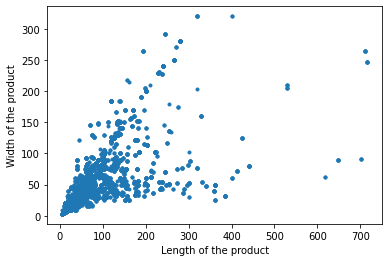

In [215]:
plt.xlabel("Length of the product")
plt.ylabel("Width of the product")
plt.scatter(df_dt_to_per_vpl["L"], df_dt_to_per_vpl["W"], marker=".")

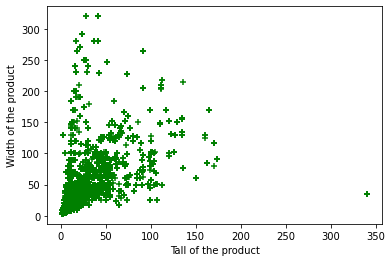

In [216]:
plt.xlabel("Tall of the product")
plt.ylabel("Width of the product")
plt.scatter(df_dt_to_per_vpl["T"], df_dt_to_per_vpl["W"], color="green", marker="+")

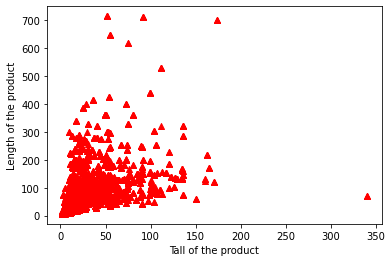

In [217]:
plt.xlabel("Tall of the product")
plt.ylabel("Length of the product")
plt.scatter(df_dt_to_per_vpl["T"], df_dt_to_per_vpl["L"], color="red", marker="^")

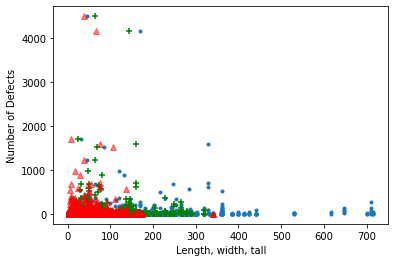

In [218]:
plt.xlabel("Length, width, tall")
plt.ylabel("Number of Defects")
plt.scatter(df_dt_to_per_vpl["L"], df_dt_to_per_vpl["defect_rate"], marker=".")
plt.scatter(df_dt_to_per_vpl["W"], df_dt_to_per_vpl["defect_rate"], marker="+", color="green")
plt.scatter(df_dt_to_per_vpl["T"], df_dt_to_per_vpl["defect_rate"], marker="^", color="red", alpha=0.5)

Looking at the relation between Length and Width of the products we can see some possible relationship between the two variables, but not much. The Tallness and Width don't seem to be related and the Tall and the Length are also not related. Based on the last figure plotting the length, width and tall values against the defect rate it can be observed that defects on tall values (red) occure mostly between 0 - 200, while the width defects occure mostly between 0-320, and the length is more spread out over the entire plot.   

#### Creating the simple models & determine the scores

In [219]:
target_simple = df_dt_to_per_vpl["defect_rate"]
features_simple = df_dt_to_per_vpl[['L', 'W','T']]
y_simple = target_simple.values 
X_simple = features_simple.values 

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_simple, y_simple, test_size=0.2, random_state=123)

simple_linear = LinearRegression()
simple_tree = DecisionTreeRegressor(max_depth=10)
simple_forest = RandomForestRegressor(n_estimators=15)
simple_knn = KNeighborsRegressor(n_neighbors=5) 

simple_linear.fit(X_train_simple, y_train_simple)
simple_forest.fit(X_train_simple, y_train_simple)
simple_tree.fit(X_train_simple, y_train_simple)
simple_knn.fit(X_train_simple, y_train_simple)

simple_models = {
    "simple linear": simple_linear,
    "simple decision tree": simple_tree,
    "simple forest": simple_forest,
    "simple knn": simple_knn
}

df_simple_scores = pd.DataFrame()
for model_name, simple_model in simple_models.items():
    index = list(simple_models.keys()).index(model_name)
    y_train_prediction = simple_model.predict(X_train_simple)
    y_test_prediction = simple_model.predict(X_test_simple)
    df_simple_scores.at[index, "model"] = model_name
    df_simple_scores.at[index, "MAE train"] = mean_absolute_error(y_train_simple, y_train_prediction) 
    df_simple_scores.at[index, "MAE test"] = mean_absolute_error(y_test_simple, y_test_prediction) 
    df_simple_scores.at[index, "MSE train"] = mean_squared_error(y_train_simple, y_train_prediction)
    df_simple_scores.at[index, "MSE test"] = mean_squared_error(y_test_simple, y_test_prediction)
    df_simple_scores.at[index, "R2 train"] = r2_score(y_train_simple, y_train_prediction)
    df_simple_scores.at[index, "R2 test"] = r2_score(y_test_simple, y_test_prediction)
df_simple_scores = df_simple_scores.style.background_gradient(cmap="YlOrRd", subset=["MAE train", "MAE test", "MSE train", "MSE test"]).background_gradient(cmap="Greens", subset=["R2 train", "R2 test"])
df_simple_scores

,model,MAE train,MAE test,MSE train,MSE test,R2 train,R2 test
0,simple linear,15.200449,12.566375,9626.009997,1141.221400,0.007785,0.006440
1,simple decision tree,10.853262,10.027731,5742.666428,1718.569880,0.408066,-0.496206
2,simple forest,10.469236,10.250429,5884.981866,1988.594511,0.393397,-0.731293
3,simple knn,11.072445,9.907521,6352.729513,1619.009719,0.345183,-0.409528


Unfortunatly, all the models don't fit the L, W, T data. The linear regression, decision tree, forest and knn are both underfitted, even when changing the different parameters.